In [41]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
# import sigmf
from sigmf import sigmffile, SigMFFile
from signals.detail import detail
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Conv2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras import Sequential

## Load the dataset


/home/shane/.local/share/virtualenvs/cs5033-final-project-sO7u1n24/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


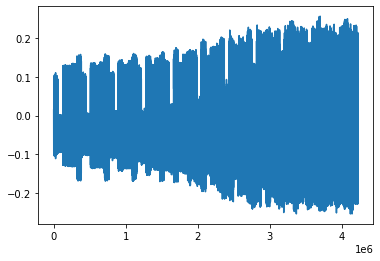

In [42]:
filename = 'data/dataset'
sigFile = sigmffile.fromfile(filename, skip_checksum=True)
annotations = sigFile.get_annotations()
nSignals = len(annotations)
nSamps = int(sigFile.sample_count/nSignals)
# The input data is a tensor with shape nSignals x 2 x nSamps
x = np.zeros((nSignals, 2, nSamps))
labels = np.array(['']*nSignals, dtype=object)
noiseVoltages = np.zeros((nSignals,))
plt.plot(sigFile.read_samples())
for iSignal, annotation in enumerate(annotations):
    # Label of the current signal
    labels[iSignal] = annotation[SigMFFile.LABEL_KEY]
    # Start index of the current signal
    annotationStart = annotation[SigMFFile.START_INDEX_KEY]
    # Length of the current signal in samples
    annotationLength = annotation[SigMFFile.LENGTH_INDEX_KEY]
    # Data for the current signal
    samples = sigFile.read_samples(annotationStart, annotationLength)
    noiseVoltages[iSignal] = float(annotation[detail.DETAIL_KEY][detail.NOISE_VOLTAGE_KEY])
    # Store the signal data in the input tensor
    # Note: Since the data is complex, we need to split it into real and imaginary
    # parts because neural networks have trouble handling complex data
    x[iSignal, 0, :] = np.real(samples)
    x[iSignal, 1, :] = np.imag(samples)
# Number of unique signal classes
classes = np.unique(labels)

## Partition the data into training and testing sets


In [43]:
# np.random.seed(0)
nTrain = int(0.5*nSignals)
nTest = nSignals - nTrain
# Since the input data is heavily structured, we need to shuffle the data to
# form the training and testing sets
trainIndex = np.random.permutation(range(0, nSignals))[0:nTrain]
# The test set is the complement of the training set
testIndex = list(set(range(0, nSignals)) - set(trainIndex))
# Generate the train/test examples/labels
xTrain = x[trainIndex, :, :]
xTest = x[testIndex, :, :]
labelTrain = labels[trainIndex]
labelTest = labels[testIndex]
inputShape = list(xTrain.shape[1:])
print(xTrain.shape)

(16500, 2, 128)


## Convert the class labels to one-hot vectors


In [44]:
def onehot(array):
  """
  Convert a list of labels to onehot representation
  """
  # Get the array of unique labels and the indices of the unique array that can
  # be used to reconstruct array
  unique, inverse = np.unique(array,return_inverse=True)
  # Each row of this identity matrix is the one-hot representation of each label
  # in unique, so we can get the one-hot encoding by choosing the corresponding
  # row for each index in inverse
  oneHot = np.eye(unique.shape[0])[inverse]
  return oneHot
yTrain = onehot(labelTrain)
yTest = onehot(labelTest)

## Build the model using Tensorflow


In [45]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Build the model
dropoutRate = 0.5
model = Sequential()
model.add(Reshape(inputShape+[1],
                  input_shape=inputShape))
model.add(ZeroPadding2D((2,0),
                        data_format='channels_first'))
model.add(Conv2D(256, (1, 3),
                 activation='relu',
                 padding='valid',
                 name='conv1'))
model.add(Dropout(dropoutRate))
model.add(ZeroPadding2D((2,0),
                        data_format='channels_first'))
model.add(Conv2D(80, (2, 3),
                 padding='valid',
                 activation='relu',
                 name='conv2'))
model.add(Dropout(dropoutRate))
model.add(Flatten())
model.add(Dense(256,
                activation='relu', kernel_initializer='he_normal', name='dense1'))
model.add(Dropout(dropoutRate))
model.add(Dense(len(classes),
                kernel_initializer='he_normal', name='dense2'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='Adam')
model.summary()

Num GPUs Available:  1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d_8 (ZeroPaddi  (None, 2, 132, 1)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 256)       1024      
                                                                 
 dropout_12 (Dropout)        (None, 2, 130, 256)       0         
                                                                 
 zero_padding2d_9 (ZeroPaddi  (None, 2, 134, 256)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (N

## Train the model

In [46]:
nEpochs = 100
batchSize = 1024
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(xTrain,yTrain,
                    batch_size=batchSize,
                    epochs=nEpochs,
                    validation_data=(xTest,yTest),
                    verbose=2,
                    callbacks = [
                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),
                      tensorboard_callback
                    ])

Epoch 1/100
17/17 - 2s - loss: 1.5443 - val_loss: 1.3507 - 2s/epoch - 101ms/step
Epoch 2/100
17/17 - 1s - loss: 1.2532 - val_loss: 1.0967 - 1s/epoch - 73ms/step
Epoch 3/100
17/17 - 1s - loss: 1.1163 - val_loss: 1.0639 - 1s/epoch - 73ms/step
Epoch 4/100
17/17 - 1s - loss: 1.0886 - val_loss: 1.0564 - 1s/epoch - 76ms/step
Epoch 5/100
17/17 - 1s - loss: 1.0574 - val_loss: 1.0343 - 1s/epoch - 73ms/step
Epoch 6/100
17/17 - 1s - loss: 1.0374 - val_loss: 1.0289 - 1s/epoch - 73ms/step
Epoch 7/100
17/17 - 1s - loss: 1.0109 - val_loss: 0.9962 - 1s/epoch - 74ms/step
Epoch 8/100
17/17 - 1s - loss: 0.9708 - val_loss: 0.9518 - 1s/epoch - 73ms/step
Epoch 9/100
17/17 - 1s - loss: 0.9189 - val_loss: 0.9142 - 1s/epoch - 74ms/step
Epoch 10/100
17/17 - 1s - loss: 0.8709 - val_loss: 0.8782 - 1s/epoch - 74ms/step
Epoch 11/100
17/17 - 1s - loss: 0.8172 - val_loss: 0.8201 - 1s/epoch - 74ms/step
Epoch 12/100
17/17 - 1s - loss: 0.7784 - val_loss: 0.8169 - 1s/epoch - 74ms/step
Epoch 13/100
17/17 - 1s - loss: 0.75

KeyboardInterrupt: 

0.564938485622406
[0.72209904 0.74198251 0.84364821 0.76433824 0.73566995 0.96251768]
[[0.72209904 0.15558019 0.02475979 0.03695492 0.05395418 0.00665188]
 [0.14686589 0.74198251 0.03316327 0.03972303 0.02478134 0.01348397]
 [0.05030764 0.06442273 0.84364821 0.02316323 0.01013391 0.00832429]
 [0.07573529 0.09595588 0.02573529 0.76433824 0.02463235 0.01360294]
 [0.15407083 0.0781307  0.01314348 0.01679445 0.73566995 0.00219058]
 [0.00742574 0.01768034 0.00459689 0.00671853 0.00106082 0.96251768]]


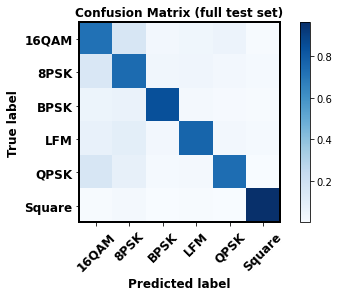

In [ ]:
score = model.evaluate(xTest,yTest,verbose=0,batch_size=batchSize)
print(score)

def confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45,fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, labels,fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=12, fontweight='bold')

# Plot confusion matrix
yPredTest = model.predict(xTest, batch_size=batchSize)
conf = np.zeros([len(classes),len(classes)])
for i in range(xTest.shape[0]):
    actual = list(yTest[i,:]).index(1)
    predicted = int(np.argmax(yPredTest[i,:]))
    conf[actual,predicted] += 1
# Normalize the confusion matrix so that each row sums to 1
for i in range(len(classes)):
    conf[i,:] = conf[i,:] / np.sum(conf[i,:])
confusion_matrix(conf, title='Confusion Matrix (full test set)',labels=classes)
# plt.title('Confusion Matrix (full test set)', fontsize=14, fontweight='bold')
plt.savefig('figures/' + 'conf_total'+'.png',bbox_inches='tight')
print(np.amax(conf,1))
print(conf)

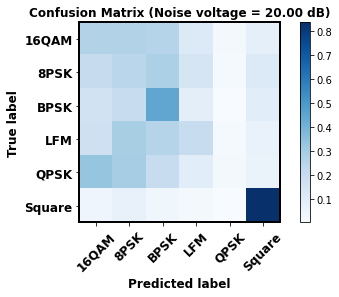

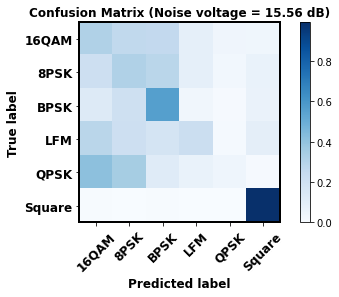

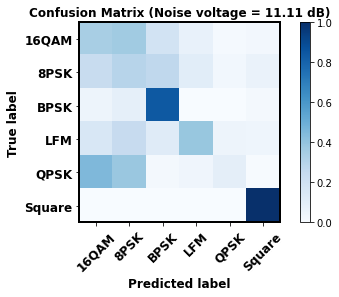

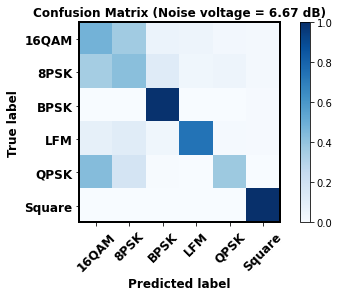

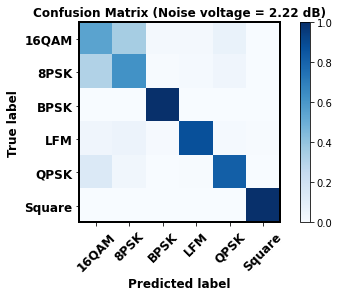

In [47]:
# Plot confusion matrix for various noise voltages
accuracy = np.zeros((0,))
for voltage in np.flip(np.unique(noiseVoltages[testIndex])):
    xTestCurrent = xTest[noiseVoltages[testIndex] == voltage]
    yTestCurrent = yTest[noiseVoltages[testIndex] == voltage]
    yPredCurrent = model.predict(xTestCurrent, batch_size=batchSize)
    # Compute confusion matrix indices
    conf = np.zeros([len(classes), len(classes)])
    for i in range(xTestCurrent.shape[0]):
        actual = list(yTestCurrent[i, :]).index(1)
        predicted = np.argmax(yPredCurrent[i, :])
        conf[actual, predicted] += 1
    # Compute classification accuracy from the confusion matrix
    accuracy = np.append(accuracy, np.trace(conf) / np.sum(conf))
    # Normalize confusion matrix
    for i in range(len(classes)):
        conf[i, :] = conf[i, :] / np.sum(conf[i, :])
    confusion_matrix(
        conf, title=f'Confusion Matrix (Noise voltage = {voltage:.2f} dB)', labels=classes)
    plt.savefig('figures/' + 'conf' +
                f'_{voltage:.2f}dB' + '.png', bbox_inches='tight')
    plt.show()

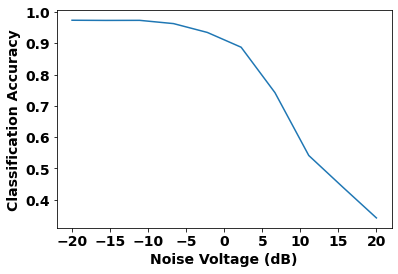

In [ ]:
# Plot classification accuracy as a function of noise voltage
plt.plot(np.flip(np.unique(noiseVoltages[testIndex])), accuracy)
plt.xlabel('Noise Voltage (dB)', fontsize=14, fontweight='bold')
plt.ylabel('Classification Accuracy', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
# plt.title('Classification accuracy vs Noise Power'
#           fontsize=14, fontweight='bold')
plt.savefig('figures/' + 'accuracy' + '.png', bbox_inches='tight')
